<a href="https://www.kaggle.com/code/sevdanuropur/feature-engineering?scriptVersionId=165387773" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Feature Engıneerıng for Womens Clothing E-Commerce Reviews

# CONTENTS:
* IMPORT LIBRARIRES
* LOAD DATA SET 
* NEW FEATURES
* ONE-HOT-ENCODER
* STANDARDIZATION
* IMPLEMENTING 6 ALGORITHMS
* CONCLUSION

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


# IMPORT LIBRARIES 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

# LOAD DATA SET

In [3]:
df_=pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")
df=df_.copy()

In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### unique #####################")
    print(dataframe.nunique())
    
check_df(df)

##################### Shape #####################
(23486, 10)
##################### Types #####################
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object
##################### NA #####################
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64
##################### unique #####################
Clothing ID                 1206
Age                           77
Title                      13993
Revi

In [6]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if str(df[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in df.columns if df[col].nunique() < 10 and df[col].dtypes in ["int64", "float64"]]

    cat_but_car = [col for col in df.columns if
                   df[col].nunique() > 20 and str(df[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 23486
Variables: 10
cat_cols: 5
num_cols: 3
cat_but_car: 2
num_but_cat: 2


In [8]:
df.groupby("Clothing ID").agg({"Recommended IND":["mean","count"]}).head(10)

Recommended IND      
                       mean count
Clothing ID                      
0                     1.000     1
1                     0.667     3
2                     1.000     1
3                     1.000     1
4                     1.000     1
5                     1.000     1
6                     1.000     1
7                     1.000     1
8                     0.571     7
9                     1.000     1

In [9]:
# a product is voted by more than one person
df["Clothing ID"].value_counts().head(10)

Clothing ID
1078    1024
862      806
1094     756
1081     582
872      545
829      527
1110     480
868      430
895      404
936      358
Name: count, dtype: int64

In [10]:
df.groupby(["Clothing ID","Rating"]).agg({"Recommended IND":"mean"}).head(10)

Recommended IND
Clothing ID Rating                 
0           5                 1.000
1           2                 0.000
            5                 1.000
2           4                 1.000
3           5                 1.000
4           5                 1.000
5           5                 1.000
6           5                 1.000
7           5                 1.000
8           1                 0.000

In [11]:
cat_cols=[col for col in cat_cols if col!= "Recommended IND"]

In [12]:
def cat_analiz(dataframe, cat_cols):
    print(pd.DataFrame({cat_cols: dataframe[cat_cols].value_counts(),
                        "Ratio": dataframe[cat_cols].value_counts() * 100 / len(df)}))
    

for col in cat_cols:
    cat_analiz(df, col)

                Division Name  Ratio
Division Name                       
General                 13850 58.971
General Petite           8120 34.574
Initmates                1502  6.395
                 Department Name  Ratio
Department Name                        
Tops                       10468 44.571
Dresses                     6319 26.905
Bottoms                     3799 16.176
Intimate                    1735  7.387
Jackets                     1032  4.394
Trend                        119  0.507
                Class Name  Ratio
Class Name                       
Dresses               6319 26.905
Knits                 4843 20.621
Blouses               3097 13.187
Sweaters              1428  6.080
Pants                 1388  5.910
Jeans                 1147  4.884
Fine gauge            1100  4.684
Skirts                 945  4.024
Jackets                704  2.998
Lounge                 691  2.942
Swim                   350  1.490
Outerwear              328  1.397
Shorts             

In [13]:
# let's do numerical analysis

def num_analiz(dataframe, num_cols, plot=False):
    quantile = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]
    print(dataframe[num_cols].describe(quantile).T)
    print("#"*30)
    if plot:
        dataframe[num_cols].hist()
        plt.title(num_cols)
        plt.show()
       
        
num_cols=[col for col in num_cols if  col !="Clothing ID"] 

for col in num_cols:
    num_analiz(df, col, False)

count   23486.000
mean       43.199
std        12.280
min        18.000
10%        28.000
20%        33.000
30%        36.000
40%        39.000
50%        41.000
60%        45.000
70%        49.000
80%        54.000
90%        61.000
99%        74.000
max        99.000
Name: Age, dtype: float64
##############################
count   23486.000
mean        2.536
std         5.702
min         0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         1.000
60%         1.000
70%         2.000
80%         3.000
90%         7.000
99%        26.000
max       122.000
Name: Positive Feedback Count, dtype: float64
##############################


In [14]:
# Let's look at the relationship of categorical variables with target
def target_analiz_cat(dataframe, cat_cols, target):
    print(pd.DataFrame({cat_cols: dataframe.groupby(cat_cols)[target].mean()}))

cat_cols= [col for col in cat_cols if col != "Recommended IND"]

for col in cat_cols:
    target_analiz_cat(df, col, "Recommended IND")

                Division Name
Division Name                
General                 0.817
General Petite          0.826
Initmates               0.852
                 Department Name
Department Name                 
Bottoms                    0.851
Dresses                    0.808
Intimate                   0.850
Jackets                    0.836
Tops                       0.815
Trend                      0.739
                Class Name
Class Name                
Blouses              0.810
Casual bottoms       1.000
Chemises             1.000
Dresses              0.808
Fine gauge           0.837
Intimates            0.857
Jackets              0.845
Jeans                0.881
Knits                0.818
Layering             0.884
Legwear              0.861
Lounge               0.860
Outerwear            0.817
Pants                0.833
Shorts               0.839
Skirts               0.846
Sleep                0.855
Sweaters             0.800
Swim                 0.806
Trend              

In [15]:
# Let's look at the analysis of numeric variables according to categorical variables

def target_analiz_num(dataframe, num_cols, target):
    print(dataframe.groupby(target)[num_cols].mean())


for col in num_cols:
    target_analiz_num(df, col, "Recommended IND")

Recommended IND
0   42.390
1   43.373
Name: Age, dtype: float64
Recommended IND
0   3.383
1   2.353
Name: Positive Feedback Count, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


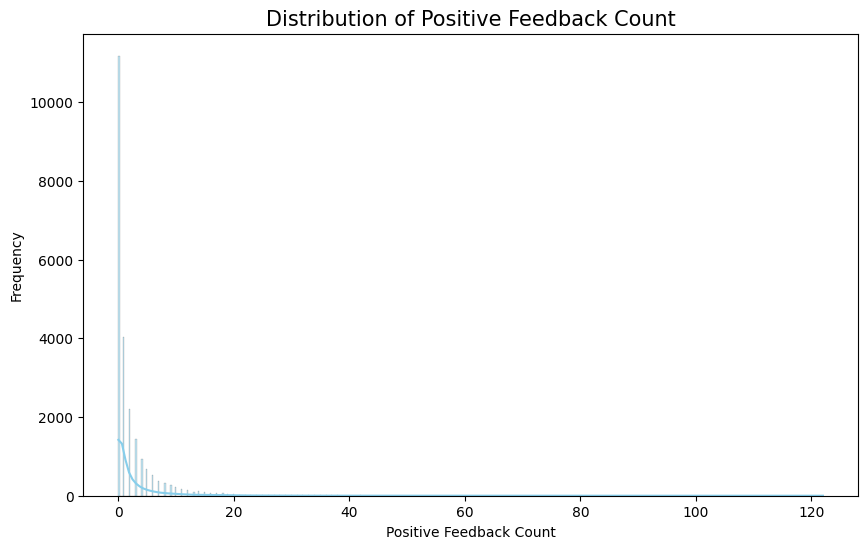

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Positive Feedback Count'], kde=True, color='skyblue')
plt.title('Distribution of Positive Feedback Count', size=15)
plt.xlabel('Positive Feedback Count')
plt.ylabel('Frequency')
plt.show()


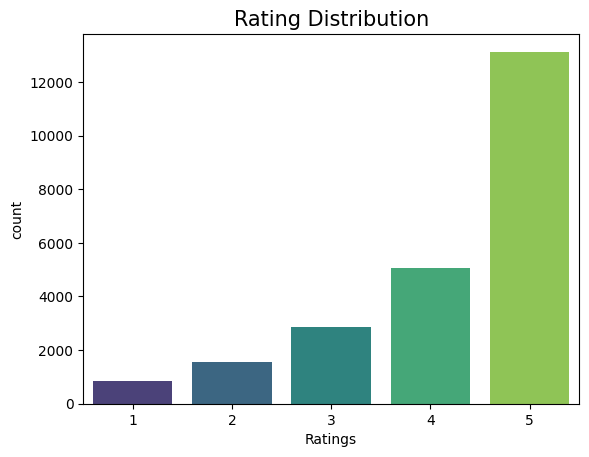

In [17]:
sns.countplot(x = 'Rating', palette='viridis', data=df)
plt.title('Rating Distribution', size=15)
plt.xlabel('Ratings')
plt.show()

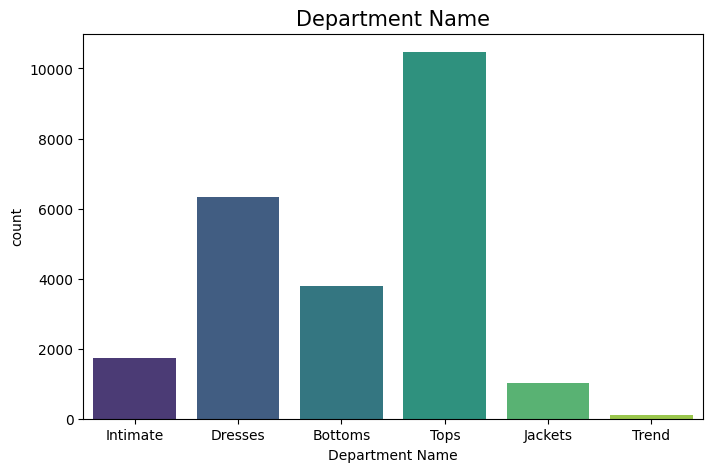

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Department Name', palette='viridis', data=df)
plt.title('Department Name', size=15)
plt.show()

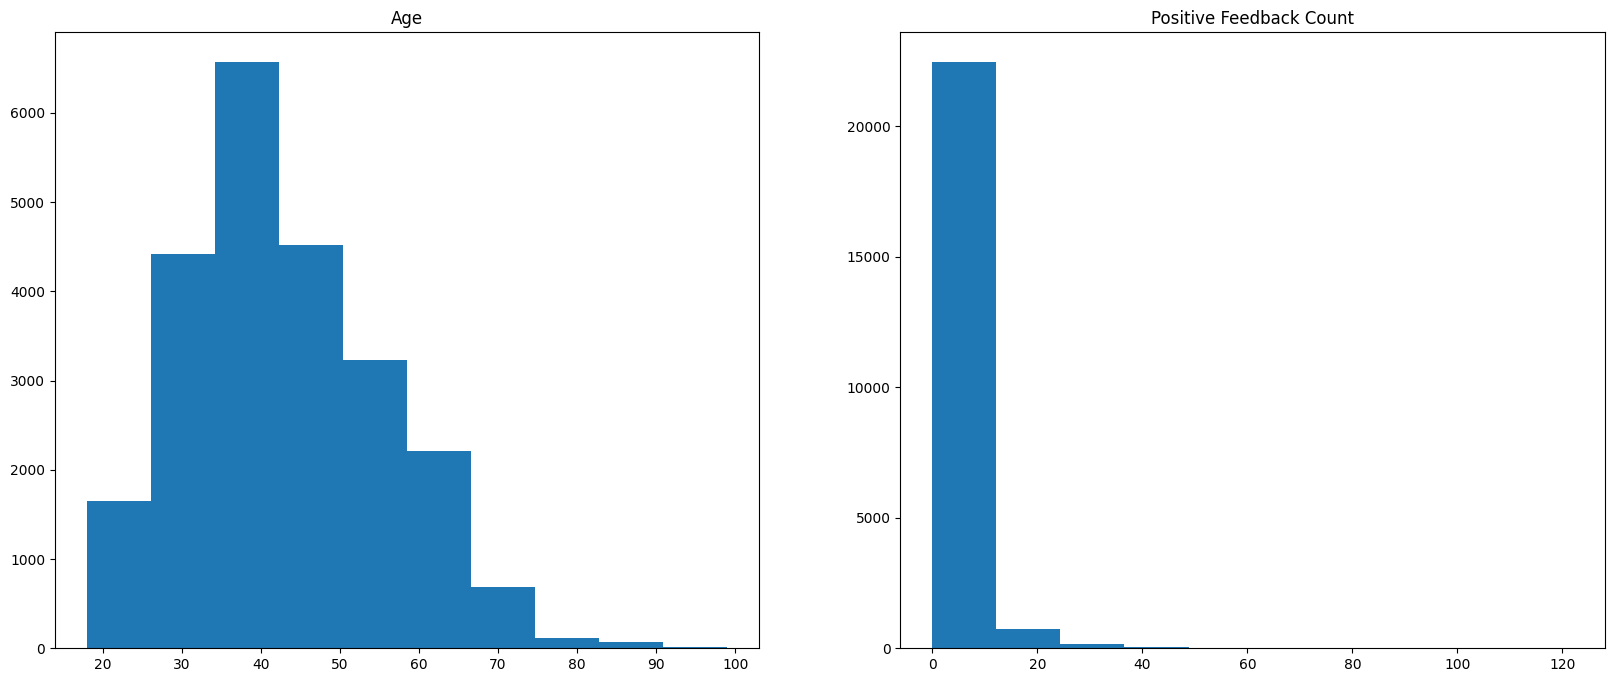

In [19]:
fig, axes = plt.subplots(1, len(num_cols), figsize=(20, 8))
for i, col in enumerate(num_cols):
    axes[i].hist(df[col])
    axes[i].set_title(col)
plt.show()

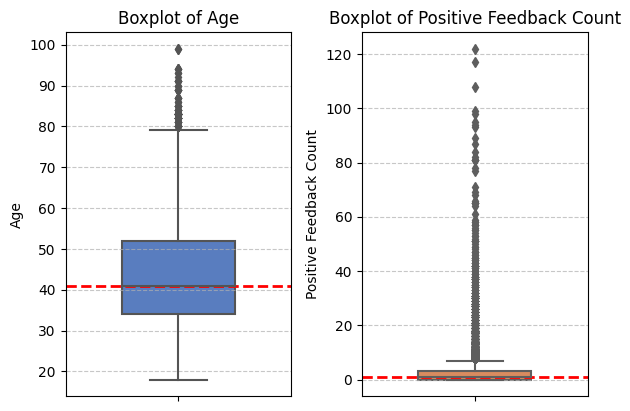

In [20]:
# LETS look at the numeric variables if there is an outlier or not 

palette = sns.color_palette('muted')

plt.figure(figsize=(12, 8))
for i, column in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[column], color=palette[i-1], width=0.5)
    plt.axhline(y=df[column].median(), color='red', linestyle='--', linewidth=2)
    plt.title(f'Boxplot of {column}', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [21]:
df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [22]:
df.drop(["Title","Review Text"],axis=1,inplace=True )

In [23]:
df.dropna(axis=0,  inplace=True)

In [24]:
# def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
#     quartile1 = dataframe[col_name].quantile(q1)
#     quartile3 = dataframe[col_name].quantile(q3)
#     interquantile_range = quartile3 - quartile1
#     up_limit = quartile3 + 1.5 * interquantile_range
#     low_limit = quartile1 - 1.5 * interquantile_range
#     return low_limit, up_limit


# def check_outlier(dataframe, col_name):
#     low_limit, up_limit = outlier_thresholds(dataframe, col_name)
#     if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
#         return True
#     else:
#         return False

# for col in num_cols:
#     print(col, check_outlier(df, col))

In [25]:
# outlier_thresholds(df,"Positive Feedback Count")

In [26]:
# def replace_with_thresholds(dataframe, variable):
#     low_limit, up_limit = outlier_thresholds(dataframe, variable)
#     dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
#     dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


# for col in num_cols:
#     replace_with_thresholds(df, col)

# for col in num_cols:
#     print(col, check_outlier(df, col))

In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 23472
Variables: 8
cat_cols: 5
num_cols: 3
cat_but_car: 0
num_but_cat: 2


In [28]:
num_cols=[col for col in num_cols if  col !="Clothing ID"] 

In [29]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,23472.000,43.201,12.281,18.000,34.000,41.000,52.000,99.000
Positive Feedback Count,23472.000,2.537,5.704,0.000,0.000,1.000,3.000,122.000


In [30]:
# selected=["AGE","RATING","RECOMMENDED IND","POSITIVE FEEDBACK COUNT"]
# data=df[selected]
# data.corr()

In [31]:
df.columns= [col.upper() for col in df.columns]
df.columns

Index(['CLOTHING ID', 'AGE', 'RATING', 'RECOMMENDED IND', 'POSITIVE FEEDBACK COUNT', 'DIVISION NAME', 'DEPARTMENT NAME', 'CLASS NAME'], dtype='object')

# NEW FEATURES

In [32]:
df["NEW_AGE"]=pd.cut(df["AGE"], bins=[18,50,max(df["AGE"])] ,labels=["mature","senior"])

In [33]:
df["NEW_RATING"]= pd.cut(df["RATING"],bins=[float('-inf'), 2, 3, float('inf')],labels=["bad","good","perfect"])

In [34]:
def new_features(dataframe,selected_col,selected_col_2,new_name):
    for i in dataframe[selected_col].value_counts().index:
        for j in dataframe[selected_col_2].value_counts().index:
            df.loc[(dataframe[selected_col]==i) & (dataframe[selected_col_2]==j),new_name]= i+"_"+j

In [35]:
new_features(df,"NEW_AGE","DIVISION NAME","NEW_AGE_DIVISION")

In [36]:
new_features(df,"NEW_AGE","DEPARTMENT NAME","NEW_AGE_DEPARTMENT")

In [37]:
new_features(df,"NEW_AGE","CLASS NAME","NEW_AGE_CLASS")

In [38]:
new_features(df,"NEW_RATING","DIVISION NAME","NEW_RATING_DIVISION")

In [39]:
new_features(df,"NEW_RATING","DEPARTMENT NAME","NEW_RATING_DEPARTMENT")

In [40]:
new_features(df,"NEW_RATING","CLASS NAME","NEW_RATING_CLASS")

In [41]:
new_features(df,"NEW_AGE_DEPARTMENT","NEW_RATING","NEW_AGE_DEPARTMENT_RATING")    

In [42]:
new_features(df,"NEW_AGE_CLASS","NEW_RATING","NEW_AGE_CLASS_RATING")  

In [43]:
def new_features_2(dataframe,selected_col,selected_col_2,new_name):
    for i in dataframe[selected_col].value_counts().index:
        for j in dataframe[selected_col_2].value_counts().index:
            df.loc[(dataframe[selected_col]==i) & (dataframe[selected_col_2]==j),new_name]= str(i) +"_"+j

new_features_2(df,"CLOTHING ID","NEW_RATING","NEW_CLOTHES_RATING")  

In [44]:
# id - rate - age
new_features(df,"NEW_CLOTHES_RATING","NEW_AGE","NEW_CLOTHES_RATING_AGE")

In [45]:
df["RATING_POSITIVE"]=df["RATING"]* df["POSITIVE FEEDBACK COUNT"]

In [46]:
df["ID_POSITIVE"]=str(df["CLOTHING ID"])+"_"+str(df["POSITIVE FEEDBACK COUNT"])

In [47]:
df["CLOTHES_ID_RATING"]=str(df["CLOTHING ID"])+"_"+ str(df["RATING"])

In [48]:
df.head()

,CLOTHING ID,AGE,RATING,RECOMMENDED IND,POSITIVE FEEDBACK COUNT,DIVISION NAME,DEPARTMENT NAME,CLASS NAME,NEW_AGE,NEW_RATING,NEW_AGE_DIVISION,NEW_AGE_DEPARTMENT,NEW_AGE_CLASS,NEW_RATING_DIVISION,NEW_RATING_DEPARTMENT,NEW_RATING_CLASS,NEW_AGE_DEPARTMENT_RATING,NEW_AGE_CLASS_RATING,NEW_CLOTHES_RATING,NEW_CLOTHES_RATING_AGE,RATING_POSITIVE,ID_POSITIVE,CLOTHES_ID_RATING
0,767,33,4,1,0,Initmates,Intimate,Intimates,mature,perfect,mature_Initmates,mature_Intimate,mature_Intimates,perfect_Initmates,perfect_Intimate,perfect_Intimates,mature_Intimate_perfect,mature_Intimates_perfect,767_perfect,767_perfect_mature,0,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...
1,1080,34,5,1,4,General,Dresses,Dresses,mature,perfect,mature_General,mature_Dresses,mature_Dresses,perfect_General,perfect_Dresses,perfect_Dresses,mature_Dresses_perfect,mature_Dresses_perfect,1080_perfect,1080_perfect_mature,20,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...
2,1077,60,3,0,0,General,Dresses,Dresses,senior,good,senior_General,senior_Dresses,senior_Dresses,good_General,good_Dresses,good_Dresses,senior_Dresses_good,senior_Dresses_good,1077_good,1077_good_senior,0,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...
3,1049,50,5,1,0,General Petite,Bottoms,Pants,mature,perfect,mature_General Petite,mature_Bottoms,mature_Pants,perfect_General Petite,perfect_Bottoms,perfect_Pants,mature_Bottoms_perfect,mature_Pants_perfect,1049_perfect,1049_perfect_mature,0,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...
4,847,47,5,1,6,General,Tops,Blouses,mature,perfect,mature_General,mature_Tops,mature_Blouses,perfect_General,perfect_Tops,perfect_Blouses,mature_Tops_perfect,mature_Blouses_perfect,847_perfect,847_perfect_mature,30,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...


In [49]:
 df.drop("NEW_CLOTHES_RATING", axis=1, inplace=True)

In [50]:
# new_age_class
df.drop("NEW_AGE_CLASS", axis=1, inplace=True)

In [51]:
df.drop(["NEW_AGE_DIVISION","NEW_CLOTHES_RATING_AGE"], axis=1, inplace=True)

In [52]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols=[col for col in cat_cols if col!= "RECOMMENDED IND"]

Observations: 23472
Variables: 19
cat_cols: 12
num_cols: 4
cat_but_car: 3
num_but_cat: 2


In [53]:
num_cols

['CLOTHING ID', 'AGE', 'POSITIVE FEEDBACK COUNT', 'RATING_POSITIVE']

In [54]:
cat_but_car

['NEW_RATING_CLASS', 'NEW_AGE_DEPARTMENT_RATING', 'NEW_AGE_CLASS_RATING']

In [55]:
cat_cols= cat_cols+ cat_but_car+ ["CLOTHING ID"]

In [56]:
df.head()

,CLOTHING ID,AGE,RATING,RECOMMENDED IND,POSITIVE FEEDBACK COUNT,DIVISION NAME,DEPARTMENT NAME,CLASS NAME,NEW_AGE,NEW_RATING,NEW_AGE_DEPARTMENT,NEW_RATING_DIVISION,NEW_RATING_DEPARTMENT,NEW_RATING_CLASS,NEW_AGE_DEPARTMENT_RATING,NEW_AGE_CLASS_RATING,RATING_POSITIVE,ID_POSITIVE,CLOTHES_ID_RATING
0,767,33,4,1,0,Initmates,Intimate,Intimates,mature,perfect,mature_Intimate,perfect_Initmates,perfect_Intimate,perfect_Intimates,mature_Intimate_perfect,mature_Intimates_perfect,0,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...
1,1080,34,5,1,4,General,Dresses,Dresses,mature,perfect,mature_Dresses,perfect_General,perfect_Dresses,perfect_Dresses,mature_Dresses_perfect,mature_Dresses_perfect,20,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...
2,1077,60,3,0,0,General,Dresses,Dresses,senior,good,senior_Dresses,good_General,good_Dresses,good_Dresses,senior_Dresses_good,senior_Dresses_good,0,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...
3,1049,50,5,1,0,General Petite,Bottoms,Pants,mature,perfect,mature_Bottoms,perfect_General Petite,perfect_Bottoms,perfect_Pants,mature_Bottoms_perfect,mature_Pants_perfect,0,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...
4,847,47,5,1,6,General,Tops,Blouses,mature,perfect,mature_Tops,perfect_General,perfect_Tops,perfect_Blouses,mature_Tops_perfect,mature_Blouses_perfect,30,0 767\n1 1080\n2 1077\n3...,0 767\n1 1080\n2 1077\n3...


# ONE-HOT ENCODER 

In [57]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [58]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [59]:
num_cols=[col for col in num_cols if col!="CLOTHING ID"]

In [60]:
# mms = MinMaxScaler()
# df[num_cols] = mms.fit_transform(df[num_cols])

# df[num_cols].head()

# STANDARDIZATION

In [61]:
rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])

df[num_cols].head()

,AGE,POSITIVE FEEDBACK COUNT,RATING_POSITIVE
0,-0.444,-0.333,-0.300
1,-0.389,1.000,1.700
2,1.056,-0.333,-0.300
3,0.500,-0.333,-0.300
4,0.333,1.667,2.700


# IMPLEMENTING ALGORITHMS 

In [62]:
y = df["RECOMMENDED IND"]
X = df.drop("RECOMMENDED IND", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

### Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46)
rf_model.fit(X_train, y_train)
y_pred_1 = rf_model.predict(X_test)
rf_accuracy= accuracy_score(y_pred_1, y_test)
rf_accuracy


0.9311520109066121

### Light Gradient Boosting Machine Classifier

In [64]:
from lightgbm import LGBMClassifier

lgbm_model= LGBMClassifier(random_state=42,verbosity=-1)
lgbm_model.fit(X_train, y_train)
y_pred_2 =lgbm_model.predict(X_test)
lgbm_accuracy= accuracy_score(y_pred_2, y_test) 
lgbm_accuracy

0.9330265848670757

### Extreme Gradient Boosting Classifier

In [65]:
from xgboost import XGBClassifier

xgm_model= XGBClassifier(random_state=42)
xgm_model.fit(X_train, y_train)
y_pred_4 =xgm_model.predict(X_test)
xgb= accuracy_score(y_pred_4, y_test)  
xgb

0.9343899113837764

### K-Nearest Neighbors Classifier

In [66]:
from sklearn.neighbors import KNeighborsClassifier

knn_model= KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_6 =knn_model.predict(X_test)
knn= accuracy_score(y_pred_6, y_test) 
knn

0.9316632583503749

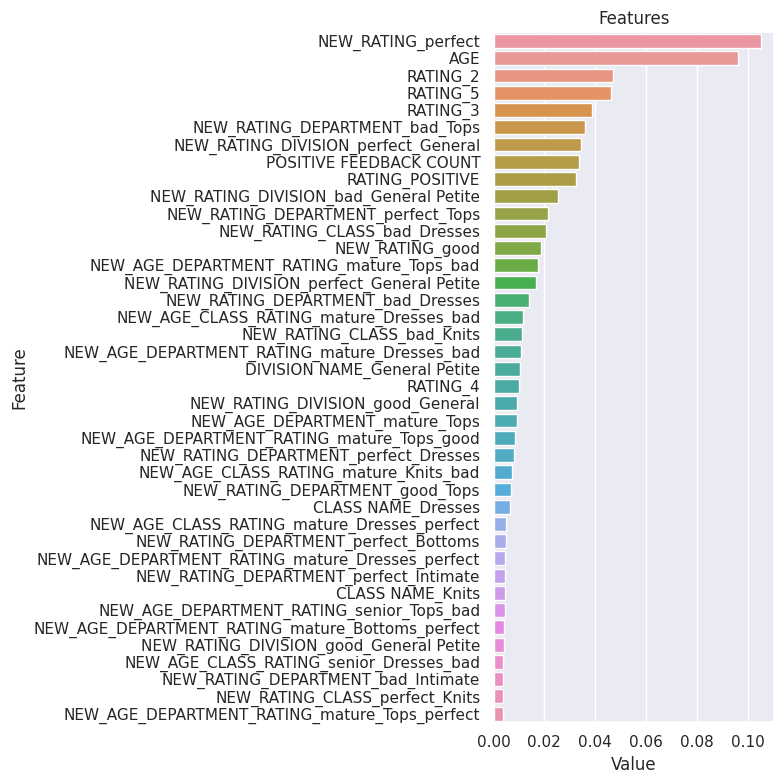

In [67]:
def plot_importance(model, features, num=40, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

# CONCLUSION 

Hello again! It was really enjoyable for me to complete this work. I tried to concretize my analyzes on Feature Engineering with this women clothing data set.I tried to add new features using other columns. If you liked the work I did on this subject, I am waiting for your comments. If you have any bugs or improvement suggestions, please share. Also, if you have suggestions or topics you would like to include in my future projects, let me know. I look forward to your contributions and thank you! 🚀📈